# Weather Classification Through Transfer Learning Based on VGG Models

## Final Project Code

### Part 1. Useful utils classes and functions

In order to make all the cells work, please download all files from https://drive.google.com/drive/folders/1GIUz-6VWF7cu60frQSVZ-WEXyareOdM5?usp=sharing

The following cell must be run to ensure the rest of the codes work.

In [1]:
import random
from keras.models import load_model
import keras
import pickle
from keras import layers
from keras import *
from keras.layers import *
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import io
# import scipy.misc
# from six import BytesIO
# from PIL import Image as im, ImageDraw, ImageFont
from PIL import Image as im
import tensorflow as tf
import os
import pathlib
%matplotlib inline

#### Image Class
The is a class we develop to benefit our segmentation precedure and hsv feature extraction process.<br>
The following cell must be run before running.

In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

class Image:
    def __init__(self,bgr_mat, one_image=True,ob_de = False):
#         self.img_path = img_path
        self.bgr_mat = bgr_mat
#         self.is_one_image = one_image
#         self.gray_mat = self.to_gray_mat()
        self.rgb_mat = cv.cvtColor(self.bgr_mat,cv.COLOR_BGR2RGB)
#         self.red,self.green,self.blue = self.to_rgb_mat() 
#         self.red_flattened = self.red.flatten()
#         self.green_flattened = self.red.flatten()
#         self.blue_flattened = self.red.flatten()
        self.hsv_mat = cv.cvtColor(self.bgr_mat,cv.COLOR_BGR2HSV)
        self.detection = self.object_detect() if ob_de else None

    def to_gray_mat(self, show=False):
        '''
        The function takes an Image instance, return its gray version in matrix form
        '''
        if show:
            gray = cv.cvtColor(self.bgr_mat, cv.COLOR_BGR2GRAY)
            cv.imshow('gray',gray)
            cv.waitKey(1000)
            return gray
        else:
            return cv.cvtColor(self.bgr_mat, cv.COLOR_BGR2GRAY)

    def to_rgb_mat(self, show=False,stack_with_zero = False):

        if show:
            cv.imshow('RGB',self.bgr_mat)
            cv.waitKey(1000)
            rgb = cv.cvtColor(self.bgr_mat,cv.COLOR_BGR2RGB)
            r,g,b = cv.split(rgb)
            if stack_with_zero:
                blank = np.zeros(self.bgr_mat.shape[:2], dtype='uint8')
                red = cv.merge([r, blank, blank])
                green = cv.merge([blank, g, blank])
                blue = cv.merge([blank, blank, b])
                return red,green,blue
            else:
                return r,g,b
        else:
            rgb = cv.cvtColor(self.bgr_mat, cv.COLOR_BGR2RGB)
            r, g, b = cv.split(rgb)
            if stack_with_zero:
                blank = np.zeros(self.bgr_mat.shape[:2], dtype='uint8')
                red = cv.merge([r, blank, blank])
                green = cv.merge([blank, g, blank])
                blue = cv.merge([blank, blank, b])
                return red, green, blue
            else:
                return r,g,b

    def hsv_normal(self,ch = False,cs = False,cv = False):
        
        h = self.hsv_stats(hsv_index = 0) if ch == False else self.hsv_stats(hsv_index = 0,value_counts = ch)

        s = self.hsv_stats(hsv_index = 1) if cs == False else (self.hsv_stats(hsv_index = 1)).value_counts()

        v = self.hsv_stats(hsv_index = 2) if cv == False else (self.hsv_stats(hsv_index = 2)).value_counts()

        return h,s,v
    
    def hsv_stats(self,hsv_index = 0,value_counts = False,):
        hue = self.hsv_mat[:,:,hsv_index].flatten()
        pds = pd.Series(hue)
        
        if value_counts:
            
            return pds.value_counts()
        else:
            return pds
        
    
        
    
    def seg_kmeans(self,k = 3,show = False,label = None,num = None,path=None,save = False):
        pixel_values = self.rgb_mat.reshape((-1,3))
        pixel_values = np.float32(pixel_values)
        criteria = (cv.TERM_CRITERIA_EPS+cv.TERM_CRITERIA_MAX_ITER,100,0.2)
        _,labels,(centers) = cv.kmeans(pixel_values,k,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
        centers = np.uint8(centers)
        labels = labels.flatten()
    
        segmanted_image = centers[labels.flatten()]
        segmanted_image = segmanted_image.reshape(self.rgb_mat.shape)
        
        if save:
            from PIL import Image as ima
            
            im = ima.fromarray(segmanted_image)
            im.save(path+f'/{label}{num}.jpg')
#         if show:
#             plt.imshow(segmanted_image)
#             if save:
#                 plt.savefig(path+f'/{label}{num}.jpg')
#             plt.show()
#             return
        
        
        
        return Image(cv.cvtColor(segmanted_image,cv.COLOR_RGB2BGR))
    
    def crop_up(self,top=0.4):
        my_shape = self.bgr_mat.shape
        
        return Image(self.bgr_mat[:round(my_shape[0]*top),:,:])
    
    def show_plt(self):
        plt.imshow(self.rgb_mat)
        plt.show()
        
    def object_detect(self, model_name='centernet_hg104_1024x1024_coco17_tpu-32',figsize = (20,20)):
        od = Object_Detecter(self.bgr_mat)
        self.detection = od.call_model(model_name,figsize)
        return self.detection
        
    def top_n_hsv(self,n=3):
        localx = []
        
        h,s,v = self.hsv_normal(value_counts=True)
#         print(h,s,v)
        localx = list(h.index[:n]/180)
        localx = localx+list(s.index[:n]/100)+list(v.index[:n]/100)  
#         if len(localx) <3*n:
#             return None
        if len(localx) <3*n:
            for i in range(10):
                localx.append(localx[-1])
                if len(localx)==3*n:
                    break
        return localx
    
    def top_n_h(self,n = 3):
        pass
    
        
           
    

####  Object_Detector Class 
This Object_Detector Class is developed to help the original Object Detection Task in our project. But this class is not used in the final project. 

The following is slighly an revision from the original TF2 ZOO2 model tutorial code on github, which can be accessed from https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_tf2_colab.ipynb

In [3]:
# # from object_detection.utils import label_map_util
# # from object_detection.utils import config_util
# # from object_detection.utils import visualization_utils as viz_utils
# # from object_detection.builders import model_builder

# class Object_Detecter:
#     def __init__(self,bgr_mat):
        
#         self.bgr_mat = bgr_mat
#         self.rgb_mat = cv.cvtColor(self.bgr_mat,cv.COLOR_BGR2RGB)
#         pass
        
#     def get_keypoint_tuples(self,eval_config):
#         """Return a tuple list of keypoint edges from the eval config.

#         Args:
#         eval_config: an eval config containing the keypoint edges

#         Returns:
#         a list of edge tuples, each in the format (start, end)
#         """
#         tuple_list = []
#         kp_list = eval_config.keypoint_edge
#         for edge in kp_list:
#             tuple_list.append((edge.start, edge.end))
#             return tuple_list


#     def call_model(self,name = 'centernet_hg104_1024x1024_coco17_tpu-8',figsize=(20,20)):
#         pipeline_config = f'../402Code/models/research/object_detection/configs/tf2/{name}.config'


#         model_dir = f'../402Code/models/research/object_detection/models_with_config/{name}/'

#         # Load pipeline config and build a detection model
#         configs = config_util.get_configs_from_pipeline_file(pipeline_config)
#         model_config = configs['model']
#         detection_model = model_builder.build(model_config=model_config, is_training=False)

#         # Restore checkpoint
#         ckpt = tf.compat.v2.train.Checkpoint(
#               model=detection_model)
#         ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

#         def get_model_detection_function(model):
#             """Get a tf.function for detection."""

#             @tf.function
#             def detect_fn(image):
#                 """Detect objects in image."""

#                 image, shapes = model.preprocess(image)
#                 prediction_dict = model.predict(image, shapes)
#                 detections = model.postprocess(prediction_dict, shapes)

#                 return detections, prediction_dict, tf.reshape(shapes, [-1])

#             return detect_fn

#         detect_fn = get_model_detection_function(detection_model)

#         label_map_path = '../402Code/models/research/object_detection/data/mscoco_label_map.pbtxt'
#         label_map = label_map_util.load_labelmap(label_map_path)
#         categories = label_map_util.convert_label_map_to_categories(label_map,max_num_classes=label_map_util.get_max_label_map_index(label_map),use_display_name=True)
#         category_index = label_map_util.create_category_index(categories)
#         label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

# #         image_dir = 'models/research/object_detection/test_images/'
# #         image_path = os.path.join(image_dir, '758801644438226_.pic.jpg')
#         image_np = self.rgb_mat

#         # Things to try:
#         # Flip horizontally
#         # image_np = np.fliplr(image_np).copy()

#         # Convert image to grayscale
#         # image_np = np.tile(
#         #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

#         input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

#         detections, predictions_dict, shapes = detect_fn(input_tensor)

#         label_id_offset = 1
#         image_np_with_detections = image_np.copy()

#         # Use keypoints if available in detections
#         keypoints, keypoint_scores = None, None
#         if 'detection_keypoints' in detections:
#             keypoints = detections['detection_keypoints'][0].numpy()
#             keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

#         viz_utils.visualize_boxes_and_labels_on_image_array(
#               image_np_with_detections,
#               detections['detection_boxes'][0].numpy(),
#               (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
#               detections['detection_scores'][0].numpy(),
#               category_index,
#               use_normalized_coordinates=True,
#               max_boxes_to_draw=200,
#               min_score_thresh=.30,
#               agnostic_mode=False,
#               keypoints=keypoints,
#               keypoint_scores=keypoint_scores,
#               keypoint_edges=self.get_keypoint_tuples(configs['eval_config']))

#         plt.figure(figsize=figsize)
#         plt.imshow(image_np_with_detections)
#         plt.title(name)
#         plt.show()
        
#         return detections

# def category():
#     label_map_path = '../402Code/models/research/object_detection/data/mscoco_label_map.pbtxt'
#     label_map = label_map_util.load_labelmap(label_map_path)
#     categories = label_map_util.convert_label_map_to_categories(label_map,max_num_classes=label_map_util.get_max_label_map_index(label_map),use_display_name=True)
#     category_index = label_map_util.create_category_index(categories)
#     return category_index


## Part 2 Dataset, Data processing and Loading Data

The original dataset is contained in different folders of images. For simplicity, we put the converted BGR arrays, segmented BGR arrays, HSV values and labels in a pickle file, which gives us a dataset.

#### Useful Functions

The following cell is composed of function that used for extract hsv features of the segmented form of the picture

In [4]:
def hsv_extract(img,seg = 0):
    im = Image(img)
    if seg != 0:
        im = im.seg_kmeans(k = seg)
    
    h_,s_,v_ = im.hsv_normal(ch=True)
    
    res = np.zeros(8)
    for idx in h_.index:
        res[idx//30]+= h_[idx]
    res = res / np.linalg.norm(res)
    res[-2] = s_.mean()/255
    res[-1] = v_.mean()/255    
    return res

def hsv_extract_cropped(img,seg = 3,top = 0.4,middle = 0.2):
    
    imgshape = img.shape[0]
    top1 = round(imgshape*top)
    middle1 = top1 + round(imgshape*middle)
    img_top = img[:top1,:,:]
    img_middle = img[top1:middle1,:,:]
    img_down = img[middle1:,:,:]

    a = hsv_extract(img_top,seg=seg)
    b = hsv_extract(img_middle,seg=seg)
    c = hsv_extract(img_down,seg=seg)
    
    res = np.hstack([a,b,c])
    return res
    
def hsv_img(img):
    a = hsv_extract(img,seg = 7)
    b = hsv_extract_cropped(img,seg = 3)
    return np.hstack([a,b])

#### Data processing (HSV)

The following cell is used for the original dataset construction. It simply generate the dataset in the form of pickle file.

In [5]:
# labels = ['rainy','snowy','foggy','sunny']
# x = []
# y = []
# x_seg = []
# hsv = []

# counter = 0

# for label in labels:
#     for i in os.listdir(f'Database/Final_dataset/{label}/'):
#         path = 'Database/Final_dataset/'+ label + '/' + i
#         if '.DS_Store' in path:
#             continue
#         img2 = cv.imread(path)
#         img2 = cv.resize(img2,(227,227))
        
# #         Image(img).show_plt()
#         x.append(img2)
#         y.append(label)
#         print(path)
#         img = Image(img2)
#         img_seg = img.seg_kmeans(k = 5)
#         x_seg.append(img_seg.bgr_mat)
#         hsv_value = img_seg.top_n_hsv()
#         hsv.append(hsv_value)
#         counter+=1
        
#         print(counter)


# #         img = cv.resize(img,(150,150))
#         # Image(img).show_plt()

# #         img = img/255

# #         res = my_model2.predict(img.reshape(1,150,150,3))[0]
# #         maxi = np.max(res)
# #         pre = np.array([0])
# #         for i in range(3):
# #             if res[i] == maxi:
# #                 pre[0]=i
# #                 break

# with open('data_set_final.pickle','wb') as f:
#     pickle.dump((x,x_seg,y,hsv),f)
    


Same procedure applied to the validation set

In [6]:
# labels = ['rainy','snowy','foggy','sunny']
# x = []
# y = []
# x_seg = []
# hsv = []

# counter = 0

# for label in labels:
#     for i in os.listdir(f'Database/Validation/{label}/'):
#         path = 'Database/Validation/'+ label + '/' + i
#         if '.DS_Store' in path:
#             continue
#         img2 = cv.imread(path)
#         img2 = cv.resize(img2,(227,227))
# #         Image(img).show_plt()
#         x.append(img2)
#         y.append(label)
#         print(path)
#         img = Image(img2)
#         img_seg = img.seg_kmeans(k = 5)
#         x_seg.append(img_seg.bgr_mat)
#         hsv_value = img_seg.top_n_hsv()
#         hsv.append(hsv_value)
#         counter+=1
        
#         print(counter)


# #         
# # img = cv.resize(img,(150,150))
#         # Image(img).show_plt()

# #         img = img/255

# #         res = my_model2.predict(img.reshape(1,150,150,3))[0]
# #         maxi = np.max(res)
# #         pre = np.array([0])
# #         for i in range(3):
# #             if res[i] == maxi:
# #                 pre[0]=i
# #                 break

# with open('data_set_validation.pickle','wb') as f:
#     pickle.dump((x,x_seg,y,hsv),f)
    

# # print(le.inverse_transform(pre))
# #     if le.inverse_transform(pre)[0]!='ra'

In [7]:
## This cell is used for hsv feature generation for each pictrue
# hsv = []
# hsv_v = []
# counter = 0
# for img in x:
#     hsv.append(hsv_img(img))
#     counter+=1
#     print(counter)

# counter = 0
# for img in x_v:
#     hsv_v.append(hsv_img(img))
#     counter+=1
#     print(counter)

## Load the Data

In [8]:
# load data in the form of x, x_seg, y,hsv
with open('data_set_final4.pickle','rb') as f:
    (x,x_seg,y,hsv)  = pickle.load(f)

with open('data_set_validation4.pickle','rb') as f:
    (x_v,x_seg_v,y_v,hsv_v) = pickle.load(f)

#### Dataset Demonstration

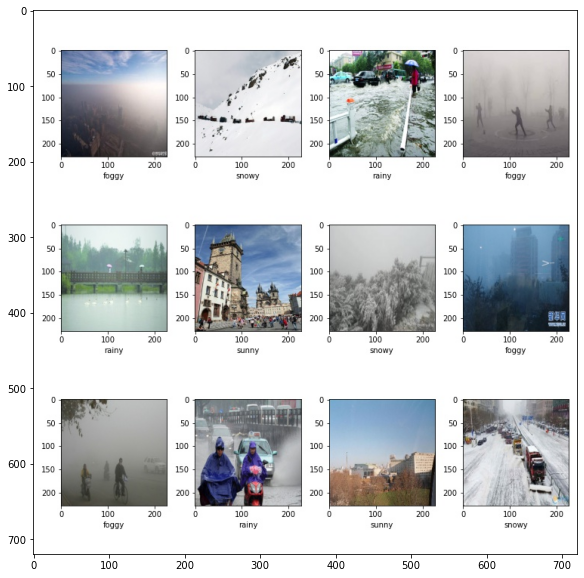

In [9]:
These function are used to generate the overview of the dataset
cont=1
plt.figure(figsize=(10,10))
for i in range(12):
    sample =  random.choice(range(len(x)))
    image = x[sample]
    category = y[sample]
    plt.subplot(3,4,i+1)
    plt.subplots_adjust(hspace=0.1,wspace = 0.1)
    plt.imshow(Image(image).rgb_mat)
    index = cont %4
#     plt.title(model_list[index-1])
    cont+=1
    plt.xlabel(category)

# plt.figure(figsize=(40,40))
plt.tight_layout()
# plt.figsize
plt.savefig('ob_sample.jpg')
plt.show()

im = cv.imread('ob_sample.jpg')
plt.figure(figsize=(10,10))
plt.tight_layout()
# plt.figsize
plt.imshow(Image(im).rgb_mat)
plt.show()


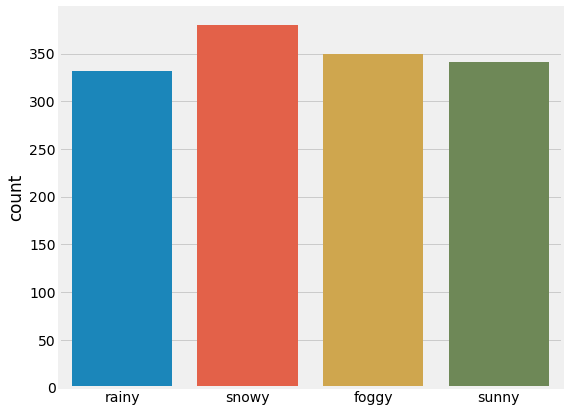

In [10]:
import seaborn as sns
plt.figure(figsize=(9,7))
plt.style.use("fivethirtyeight")
sns.countplot(x = y+y_v)
# plt.savefig('dataset.jpg')
plt.show()

 #### The following cell transfer the dataset and split the dataset

each picture is normalize by dividing 255

In [11]:
from tensorflow.keras.utils import to_categorical
# y_cat_train = to_categorical(y_train,10)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
a =y.copy()
y = le.fit_transform(y)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
x_hsv_train,x_hsv_test,y_hsv_train,y_hsv_test = train_test_split(hsv,y,test_size=0.2,random_state=42)

y_train = to_categorical(y_train,4)
y_test = to_categorical(y_test,4)

x_hsv_train = np.array(x_hsv_train)
y_hsv_test = np.array(y_hsv_test)

img_size =227

x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0


x_train = x_train.reshape(-1,img_size,img_size,3)
y_train = np.array(y_train)

x_test = x_test.reshape(-1,img_size,img_size,3)
y_test = np.array(y_test)

img_size =227

x_v = np.array(x_v)/255.0
x_seg= np.array(x_seg)/255.0


x_v = x_v.reshape(-1,img_size,img_size,3)
x_seg = x_seg.reshape(-1,img_size,img_size,3)

y_v = le.transform(y_v)
y_v = to_categorical(y_v,4)

# Part 3 Model Construction, Training, Test, and Result Demonstration

### Useful functions

In [12]:
def plot_loss(hist,model_name):
    train_accu = hist['loss']
    vali_accu = hist['val_loss']
    epochs = np.arange(1,len(train_accu)+1)
    plt.figure(figsize=(4,4))
    plt.plot(epochs,train_accu)
    plt.plot(epochs,vali_accu)
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend(['training loss','validation loss'])
    plt.title(model_name)
    plt.savefig(f'{model_name}_loss.jpg')
    plt.show()

def plot_accuracy(hist,model_name):
    train_accu = hist['accuracy']
    vali_accu = hist['val_accuracy']
    epochs = np.arange(1,len(train_accu)+1)
    plt.figure(figsize=(4,4))
    plt.plot(epochs,train_accu)
    plt.plot(epochs,vali_accu)
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.title(model_name)
    plt.legend(['training accuracy','validation accuracy'])
    plt.savefig(f'{model_name}_accuracy.jpg')
    plt.show()
    

In [13]:
# This function is used to transferred the one hot result to the original label
def inverse_catagory(pre):
    y = []
    for x in pre:
        
#         res =-1
        maxi = np.max(x)
        for i in range(4):
            if x[i] == maxi:
                y.append(i)
                break
    return y

### Model Training Function

In [14]:
## Transferred VGG traning function
def model1_train_and_savebest(x_train,y_train,x_test,y_test,batch_size,epochs,verbose = 1,patience = 5,segk = 5):
    from tensorflow.keras.applications.vgg19 import VGG19
    vgg = VGG19(weights = "imagenet",include_top=False,input_shape=(227,227,3))

    for layer in vgg.layers:
        layer.trainable = False

    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Flatten,Dense
    model =Sequential()
    model.add(vgg)
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dense(32,activation="relu"))
    model.add(Dense(4,activation="softmax"))

    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="accuracy")
    from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
    checkpoint = ModelCheckpoint(f"3_10_new37_vgg19_ori_seg{segk}_batch{batch_size}_patience{patience}_epochs{epochs}.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                                 save_weights_only=False)
    earlystop = EarlyStopping(monitor="val_accuracy",patience=patience,verbose=1)
    history =  model.fit(x_train,y_train,epochs=epochs,validation_data=(x_test,y_test),
                         batch_size=batch_size ,verbose=verbose,callbacks=[checkpoint,earlystop])
    model_name = f"3_10_new37_vgg19_ori_seg{segk}_batch{batch_size}_patience{patience}_epochs{epochs}"
    return model,history,model_name

In [15]:
## HSV-based VGG traning function
def model2_train_savebest(x_train,x_hsv_train,y_train,x_test,x_hsv_test,y_test,batch_size,epochs,verbose = 1,patience = 5,segk = 5):
    ###vgg model
    from tensorflow.keras.applications.vgg19 import VGG19
    vgg = VGG19(weights = "imagenet",include_top=False,input_shape=(227,227,3))
    
    for layer in vgg.layers:
        layer.trainable = False

    inputs = keras.Input(shape = (227,227,3))
    x = vgg(inputs)
    x = Flatten()(x)

    x = Dense(512,activation="relu")(x)
    x = Dense(128,activation="relu")(x)
    # x = Dense(64,activation="relu")(x)
    output1 = Dense(64,activation="relu")(x)

    ####hsv
    hsv_inp = keras.Input(shape = (32))
    merged = Concatenate()([output1,hsv_inp])
    merged = Dense(32,activation = 'relu')(merged)
    merged = Dense(16,activation = 'relu')(merged)
    output2 = Dense(4,activation="softmax")(merged)
    my_model = Model(inputs=[inputs,hsv_inp],outputs =[output2])
    
    run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)

    # model.compile(loss = "...", optimizer = "...", metrics = "..", options = run_opts)

    my_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']
                  )
    from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
    checkpoint = ModelCheckpoint(f"3_10_input24new37_vgg19combinedhsv_seg{segk}_batch{batch_size}_patience{patience}_epochs{epochs}.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                                 save_weights_only=False)
    earlystop = EarlyStopping(monitor="val_accuracy",patience=patience,verbose=1)
    # early_stop = EarlyStopping(monitor='val_loss',patience=5)
    history =  my_model.fit(x = [np.array(x_train),np.array(x_hsv_train)],
                        y = np.array(y_train),epochs=epochs,
                        validation_data=([np.array(x_test),np.array(x_hsv_test)],np.array(y_test)),
                        batch_size=batch_size ,verbose=1,callbacks=[earlystop,checkpoint])
    model_name = f"3_10_input24new37_vgg19combinedhsv_seg{segk}_batch{batch_size}_patience{patience}_epochs{epochs}"
    return my_model,history,model_name


### Training Process

In [16]:
# model1,hist1,model_name = model1_train_and_savebest(x_train,y_train,x_v,
#                                          y_v,batch_size=80,patience=10,epochs=100)
# with open (f'{model_name}his1.pickle','wb') as f:
#     pickle.dump(hist1.history,f)
# from keras.models import load_model
# my_model2 = load_model(f'3_10_new37_vgg19_ori_seg5_batch100_patience10_epochs100.h5')
# test_scores = my_model2.evaluate(np.array(x_test), y_test, verbose=2)



In [17]:
# model2,hist2,model_name = model2_train_savebest(x_train,x_hsv_train,y_train,
#                                      x_v,hsv_v,y_v,batch_size=30,patience=10,epochs=100)
# with open (f'{model_name}his1.pickle','wb') as f:
#     pickle.dump(hist2.history,f)

# my_model2 = load_model(f'{model_name}.h5')
# test_scores = my_model2.evaluate([np.array(x_test),np.array(x_hsv_test)], y_test, verbose=2)

### Load the pretrained model

In [18]:
from keras.models import load_model
my_model3 = load_model(f'3_10_input24new37_vgg19combinedhsv_seg5_batch20_patience10_epochs100 (1).h5')
# print(my_model3.evaluate([np.array(x_test),np.array(x_hsv_test)],np.array(y_test)))

my_model6 = load_model(f'3_10_new37_vgg19_ori_seg5_batch100_patience10_epochs100.h5')
# print(my_model6.evaluate(np.array(x_test),np.array(y_test)))





In [19]:
with open('3_10_input24new37_vgg19combinedhsv_seg5_batch20_patience10_epochs100his1 (1).pickle','rb') as f:
    data1 = pickle.load(f)

with open('3_10_new37_vgg19_ori_seg5_batch100_patience10_epochs100his1.pickle','rb') as f:
    data2 = pickle.load(f)

### Visualize training error and loss

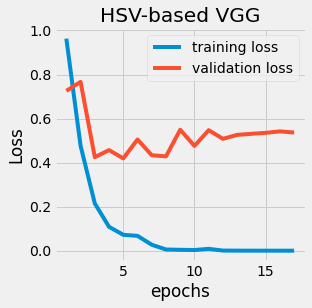

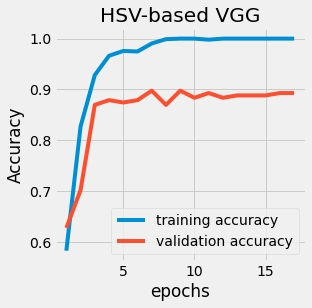

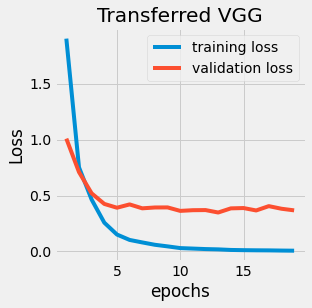

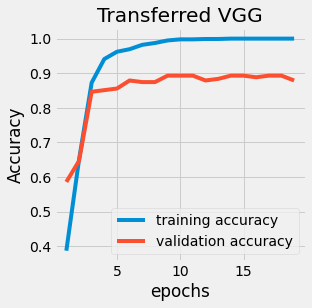

In [20]:
plot_loss(data1,model_name='HSV-based VGG')
plot_accuracy(data1,'HSV-based VGG')
plot_loss(data2,model_name='Transferred VGG')
plot_accuracy(data2,'Transferred VGG')

### Testing

##### Load the history of the model training

The left number is the testing loss of the function; the right number is the testing accuarcy

In [21]:
print(my_model3.evaluate([np.array(x_test),np.array(x_hsv_test)],np.array(y_test)))
print(my_model6.evaluate(np.array(x_test),np.array(y_test)))


8/8 [==============================] - 39s 5s/step - loss: 0.3197 - accuracy: 0.9160
[0.31969693303108215, 0.9159663915634155]
8/8 [==============================] - 37s 5s/step - loss: 0.3067 - accuracy: 0.8950
[0.3066558539867401, 0.894957959651947]


### Visualize testing results

In [22]:
y_test2 = inverse_catagory(y_test)

In [23]:
pred1 = my_model3.predict([np.array(x_test),np.array(x_hsv_test)])
pred_inversed1 = inverse_catagory(pred1)

# y_test = inverse_catagory(y_test)

from sklearn.metrics import f1_score,confusion_matrix,classification_report,accuracy_score

print(classification_report(y_test2,pred_inversed1))
print(accuracy_score(y_test2,pred_inversed1))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93        59
           1       0.85      0.93      0.88        54
           2       0.95      0.86      0.90        69
           3       0.95      0.95      0.95        56

    accuracy                           0.92       238
   macro avg       0.92      0.92      0.92       238
weighted avg       0.92      0.92      0.92       238

0.9159663865546218


In [24]:
pred2 = my_model6.predict(np.array(x_test))
pred_inversed2 = inverse_catagory(pred2)

from sklearn.metrics import f1_score,confusion_matrix,classification_report

print(classification_report(y_test2,pred_inversed2))
print(accuracy_score(y_test2,pred_inversed2))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        59
           1       0.86      0.89      0.87        54
           2       0.95      0.83      0.88        69
           3       0.91      0.93      0.92        56

    accuracy                           0.89       238
   macro avg       0.90      0.90      0.90       238
weighted avg       0.90      0.89      0.89       238

0.8949579831932774


**Since we use LabelEncoder from sklearn, we can see that the mapping is 0:foggy,1:rainy,2:snowy,3:sunny**

In [25]:
pred_inversed2[:10]

[2, 3, 3, 1, 3, 2, 3, 0, 2, 2]

In [26]:
le.inverse_transform(pred_inversed2[:10])

array(['snowy', 'sunny', 'sunny', 'rainy', 'sunny', 'snowy', 'sunny',
       'foggy', 'snowy', 'snowy'], dtype='<U5')

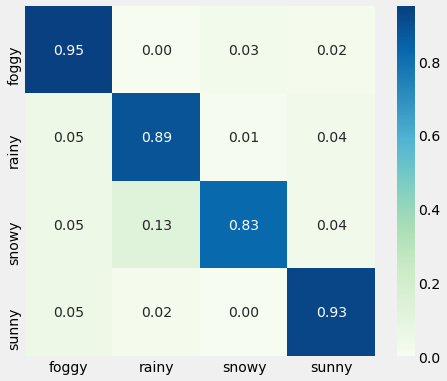

In [27]:
# sns. set_style(style = 'whitegrid') 
plt.figure(figsize = (7,6))
cf1 = confusion_matrix(y_test2,pred_inversed2)
cf2 = cf1/np.sum(cf1,axis = 1)
sns.heatmap(pd.DataFrame(cf2,index = ['foggy','rainy','snowy','sunny'],columns= ['foggy','rainy','snowy','sunny']),
  cmap="GnBu",fmt='.2f',annot=True)
plt.savefig('cfmatrix_for_ori.jpg')
plt.show();

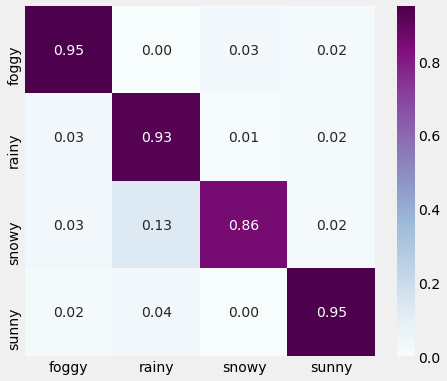

In [28]:
# sns. set_style(style = 'whitegrid') 
plt.figure(figsize = (7,6))
cf1 = confusion_matrix(y_test2,pred_inversed1)
cf2 = cf1/np.sum(cf1,axis = 1)
sns.heatmap(pd.DataFrame(cf2,index = ['foggy','rainy','snowy','sunny'],columns= ['foggy','rainy','snowy','sunny']),
  cmap="BuPu",fmt='.2f',annot=True)
plt.savefig('cfmatrix_for_hsv.jpg')
plt.show();

## Samples

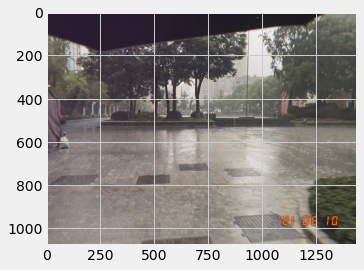

['rainy']


In [29]:
img = cv.imread(f'27931646745671_.pic_hd.jpg')
Image(img).show_plt()
img = cv.resize(img,(227,227))

x_hsv = hsv_img(img)
img = img/255

img = img.reshape((1,227,227,3))
y = my_model3.predict([img,x_hsv.reshape((1,32))])[0]

res = []
maxi = np.max(y)
for i in range(4):
    if y[i] == maxi:
        res.append(i)
        break


print(le.inverse_transform(res))